In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
data=pd.read_csv('/content/gdrive/MyDrive/Machine Learning/Bengaluru_House_Data.csv')

In [3]:
data.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [4]:
# column removing for a getting a simpler dataset
dataset=data.drop(['area_type','balcony','society','availability'],axis='columns')
dataset

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00
...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453,4.0,231.00
13316,Richards Town,4 BHK,3600,5.0,400.00
13317,Raja Rajeshwari Nagar,2 BHK,1141,2.0,60.00
13318,Padmanabhanagar,4 BHK,4689,4.0,488.00


# DATA CLEANING 

In [5]:
dataset = dataset.dropna()
dataset.isnull().sum() # print the number of NA values exist

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [6]:
dataset['size'].unique()
dataset['BHK']=dataset['size'].apply(lambda x: int(x.split(' ')[0]))  # eg. x='2 BHK' ; x.split(' ')[0]=2 ; and then typecast to integer
dataset=dataset.drop('size',axis='columns')
dataset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,location,total_sqft,bath,price,BHK
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2


In [7]:
dataset.total_sqft.unique()
# all the data are not float. Check the other type of values like range etc.
def is_float(x):
  try:
    float(x)
  except:
    return True
  return False

dataset[dataset['total_sqft'].apply(is_float)]

,location,total_sqft,bath,price,BHK
30,Yelahanka,2100 - 2850,4.0,186.000,4
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,43.490,2
188,KR Puram,1015 - 1540,2.0,56.800,2
...,...,...,...,...,...
12975,Whitefield,850 - 1060,2.0,38.190,2
12990,Talaghattapura,1804 - 2273,3.0,122.000,3
13059,Harlur,1200 - 1470,2.0,72.760,2
13265,Hoodi,1133 - 1384,2.0,59.135,2


In [8]:
# coverting the range by average value and simply ignoring the other types

def fun(x):
  tokens=x.split('-')
  if(len(tokens)==2):
    return (float(tokens[0])+float(tokens[1]))/2
  try:
    return float(x)
  except:
    return None

#fun('2100 - 2850')
dataset1=dataset.copy()
dataset1['total_sqft']=dataset1['total_sqft'].apply(fun)

# Feature Engineeting

In [9]:
print(type(dataset1['total_sqft'][0]))

<class 'numpy.float64'>


In [10]:
# Converting total_sqft and price in one column

dataset1['price_per_sqft']=dataset1['price']*100000/dataset1['total_sqft']
dataset1.head()

,location,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [11]:
print(len(dataset1['location'].unique()))
# We will cutout those locations who have 1 or 2 datapoint
dataset1['location']=dataset1['location'].apply(lambda x:x.strip()) # just to delete extra space

1304


In [12]:
location_stats=dataset1.groupby('location')['location'].agg('count')
location_stats=location_stats.sort_values(ascending=False)

In [13]:
len(location_stats[location_stats<10]) # it shows how many location have <10 datapoints
other_locations=location_stats[location_stats<10]
other_locations

location
Chandra Layout        9
Jakkur Plantation     9
2nd Phase JP Nagar    9
Yemlur                9
Mathikere             9
                     ..
LIC Colony            1
Kuvempu Layout        1
Kumbhena Agrahara     1
Kudlu Village,        1
1 Annasandrapalya     1
Name: location, Length: 1039, dtype: int64

In [14]:
len(dataset1['location'].unique())

1293

In [15]:
dataset1['location']=dataset1['location'].apply(lambda x: 'other' if x in other_locations else x)

In [16]:
len(dataset1['location'].unique())

255

# Outlier Removal

In [17]:
# there are some dataset where there is <300 sqft per bhk and tht is anomally
dataset1[dataset1['total_sqft']/dataset1['BHK']<300]
dataset2 = dataset1[~(dataset1['total_sqft']/dataset1['BHK']<300)]

In [18]:
# there are datapoints where Price_per_sqft value is very less or extremely high
dataset2.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [19]:
def remove_outlier(df):
  data_out= pd.DataFrame()
  for key,subdf in df.groupby('location'):
    m=np.mean(subdf.price_per_sqft)
    st=np.std(subdf.price_per_sqft)
    reduce_df=subdf[(subdf.price_per_sqft> (m-st)) & (subdf.price_per_sqft< (m+st))]
    data_out=pd.concat([data_out,reduce_df],ignore_index=True)
  return data_out

dataset2=remove_outlier(dataset2)

In [20]:
# there are some point whose 2BHK values are less than 1BHK for same sqft area... same for 3BHK and 2BHK
import matplotlib
def scatterplot(df,location):
  bhk2=df[(df.location==location)&(df.BHK==2)]
  bhk3=df[(df.location==location)&(df.BHK==3)]
  #matplotlib.rcParams['figure.figsize']=(15,10)
  plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK',s=50)
  plt.scatter(bhk3.total_sqft,bhk3.price,marker='+',color='green',label='3 BHK',s=50)
  plt.xlabel='Total Square Feet Area'
  plt.ylable='Price'
  plt.legend()

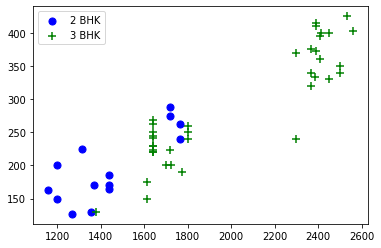

In [21]:
scatterplot(dataset2,'Rajaji Nagar')

In [22]:
def remove_bhk_outlier(df):
  exclude_index=np.array([])
  for location,location_df in df.groupby('location'):
    bhk_stats={}
    for bhk,bhk_df in location_df.groupby('BHK'):
      bhk_stats={
          'mean': np.mean(bhk_df.price_per_sqft),
          'std': np.std(bhk_df.price_per_sqft),
          'count': bhk_df.shape[0]
      }
    for bhk,bhk_df in location_df.groupby('BHK'):
      stats=bhk_stats.get(bhk-1)
      if stats and stats['count']>5:
        exclude_index=np.append(exclude_index,bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
  return df.drop(exclude_index,axis='index')

dataset2=remove_bhk_outlier(dataset2)

In [23]:
final_dataset= dataset2.drop(['price_per_sqft'],axis='columns')
final_dataset.head()

,location,total_sqft,bath,price,BHK
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


In [24]:
# as the location is string so we have to encode it into number
dummies =pd.get_dummies(final_dataset.location)
dummies.head()

,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 1st Stage,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,...,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 1 HSR Layout,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
dataframe = pd.concat([final_dataset,dummies.drop('other',axis='columns')],axis='columns') 
# we have to drop 'other' column and take 1 less column to avoid dummy variable trap
dataframe=dataframe.drop(['location'],axis='columns')
dataframe.head()

,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 1st Stage,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,...,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 1 HSR Layout,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Dividing the dataset into Independent and Dependent Variable**

In [26]:
X=dataframe.drop('price',axis='columns')
Y=dataframe.price

# Model Building

In [27]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=5)

# Checking the accuracy for Linear Regression 
from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression()
lr_reg.fit(X_train,Y_train)
lr_reg.score(X_test,Y_test)

0.8457884850346353

In [28]:
# Checking the accuracy for K-fold Cross Validation 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
cross_val_score(LinearRegression(),X,Y,cv=cv)

array([0.87372171, 0.82991888, 0.79602847, 0.81446789, 0.76847249])

In [29]:
X.columns
#np.where(X.columns=='2nd Phase Judicial Layout')[0][0]

Index(['total_sqft', 'bath', 'BHK', '1st Block Jayanagar',
       '1st Block Koramangala', '1st Phase JP Nagar',
       '2nd Phase Judicial Layout', '2nd Stage Nagarbhavi',
       '5th Block Hbr Layout', '5th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=257)

In [30]:
def predict_price(location,sqft,bath,bhk):
  loc_index=np.where(X.columns==location)[0][0]
  x=np.zeros(len(X.columns))
  x[0]=sqft
  x[1]=bath
  x[2]=bhk
  if loc_index>=0:
    x[loc_index]=1
  return lr_reg.predict([x])[0]

In [31]:
predict_price('Indira Nagar',1000,2,2)

174.0297017326419

# Saving The Model

In [33]:
import pickle
file_name='Price_Detection_model.pickle'
with open(file_name,'wb') as f:
  pickle.dump(lr_reg,f)

In [34]:
!mv Price_Detection_model.pickle '/content/gdrive/MyDrive/Machine Learning'

In [37]:
import json
columns={
    'data_columns': [col.lower() for col in X.columns]
}
with open('Columns.json','w') as f:
  f.write(json.dumps([columns]))

In [38]:
!mv Columns.json '/content/gdrive/MyDrive/Machine Learning'